# Continual Learning with Hypernetworks

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
# Hyperparameters
SEED = 100
BATCH_SIZE = 32
NUM_TASKS = 3
DATALEN_TRAIN = 100
DATALEN_VAL = 100

In [3]:
def check_cuda():
    """
    Checks if GPU is available.
    """    
    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    return cuda_available, device

def set_seed(seed=1000):
    """
    Sets the seed for reproducability
    """
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    cuda_available, _ = check_cuda()
    if cuda_available:
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)

In [4]:
class ToyRegressionDataset(Dataset):
    """
    Dataset class for the toy regression task
    """

    def __init__(self, task_num, datalen=100, epsilon=0.05):
        """
        Args:
            task_num (int): ID of the task to generate.
            datalen (int): Number of data points in each task.
            epsilon (float): Noise for target generation
        """
        # Only 3 tasks can be defined
        assert task_num in [0,1,2]

        # Functions for the 3 tasks
        true_outputs = [lambda x: x+3.0, lambda x: 2.0*(x**2.0) -1, lambda x: (x-3.0)**3]

        # Input domains for the 3 tasks
        domains = [[-4.0, -2.0], [-1.0, 1.0], [2.0, 4.0]]

        self.x = torch.Tensor(datalen, ).uniform_(domains[task_num][0], domains[task_num][1])
        self.y_true = true_outputs[task_num](self.x)
        self.y = self.y_true + torch.normal(mean=0.0, std=epsilon, size=(datalen,))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = {'x': self.x[idx], 'y_true': self.y_true[idx], 'y': self.y[idx]}

        return sample

In [5]:
def create_dataloaders(num_tasks, datalen_train, datalen_val, batch_size, seed):
    """
    Creates training and validation dataloaders for the different tasks
    
    Args:
        num_tasks (int): Total number of tasks
        datalen_train (int): Length of each training dataset
        datalen_val (int): Length of each validation dataset
        batch_size (int):  Length of batch size for training
        seed (int): Random seed for reproducability
    """

    dataloaders = list()

    for task_id in range(num_tasks):

        dataset = ToyRegressionDataset(task_num=task_id, datalen=(datalen_train+datalen_val))
        train_data, val_data = random_split(dataset,
                                            [datalen_train, datalen_val], 
                                            generator=torch.Generator().manual_seed(seed))

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=0)

        dataloaders.append({'train': train_loader, 'val': val_loader})

    return dataloaders

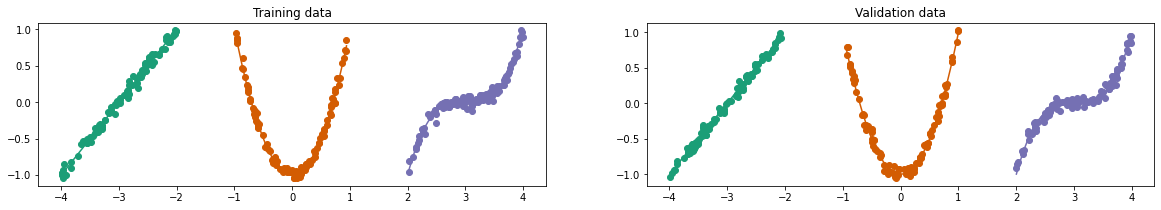

In [6]:
dataloaders = create_dataloaders(num_tasks=NUM_TASKS,
                                 datalen_train=DATALEN_TRAIN,
                                 datalen_val=DATALEN_VAL,
                                 batch_size=BATCH_SIZE,
                                 seed=SEED)

colors = ['#1B9E77', '#D35C02', '#7570B3']

fig, ax = plt.subplots(1,2,figsize=(20,3))

for task_id in range(NUM_TASKS):
    
    train_loader = dataloaders[task_id]['train']
    val_loader = dataloaders[task_id]['val']
    
    for ax_id, data_loader in enumerate([train_loader, val_loader]):
        x, y, y_true = list(), list(), list()

        for sample in data_loader:
            x.extend(list(sample['x'].view(-1).numpy()))
            y_true.extend(list(sample['y_true'].view(-1).numpy()))
            y.extend(list(sample['y'].view(-1).numpy()))

        x = np.array(x)
        y_true = np.array(y_true)
        y = np.array(y)

        sort_idx = np.argsort(x)
        plot_x = x[sort_idx]
        plot_y_true =  y_true[sort_idx]
        plot_y = y[sort_idx]
        ax[ax_id].scatter(plot_x, plot_y, color=colors[task_id])
        ax[ax_id].plot(plot_x, plot_y_true, color=colors[task_id])

_ = ax[0].set_title('Training data')
_ = ax[1].set_title('Validation data')


In [7]:
def init_params(weights, bias):
    # Initialize weights
    nn.init.kaiming_uniform_(weights, a=math.sqrt(5))

    # Initialize bias
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weights)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(bias, -bound, bound)

In [8]:
def calc_delta_theta(optimizer, use_sgd_change, lr=None, detach_dt=True):
    """
    The original function can be found at https://git.io/JEHbH
    
    Calculate :math:`\Delta\theta`, i.e., the change in trainable parameters
    (:math:`\theta`) in order to minimize the task-specific loss.
    
    **Note**, one has to call :func:`torch.autograd.backward` on a
    desired loss before calling this function, otherwise there are no gradients
    to compute the weight change that the optimizer would cause. 
    
    Hence, this method is called in between :func:`torch.autograd.backward` and
    :meth:`torch.optim.Optimizer.step`.
    
    Note, by default, gradients are detached from the computational graph.
    Args:
        optimizer: The optimizer that will be used to change :math:`\theta`.
        use_sgd_change: If :code:`True`, then we won't calculate the actual step
            done by the current optimizer, but the one that would be done by a
            simple SGD optimizer.
        lr: Has to be specified if `use_sgd_change` is :code:`True`. The
            learning rate of the optimizer.
        detach_dt: Whether :math:`\Delta\theta` should be detached from the
            computational graph. Note, in order to backprop through
            :math:`\Delta\theta`, you have to call
            :func:`torch.autograd.backward` with `create_graph` set to
            :code:`True` before calling this method.
    Returns:
        :math:`\Delta\theta`
    """
    assert(not use_sgd_change or lr is not None)

    if use_sgd_change:
        ret = []
        for g in optimizer.param_groups:
            for p in g['params']:
                if detach_dt:
                    ret.append(-lr * p.grad.detach().clone())
                else:
                    ret.append(-lr * p.grad.clone())
        return ret
    else:
        if isinstance(optimizer, optim.Adam):
            return adam_step(optimizer, detach_dp=detach_dt)
        else:
            raise NotImplementedError(f'Not implemented for optimizer {optimizer.type}')
                                      
            
def adam_step(optimizer, detach_dp=True):
    """
    The original function can be found at https://git.io/JEHbH
    
    Performs a single optimization step using the Adam optimizer. The code
    has been copied from: https://git.io/fjYP3
        
    Note, this function does not change the inner state of the given
    optimizer object.
    
    Note, gradients are cloned and detached by default.
    
    Args:
        optimizer: An instance of class :class:`torch.optim.Adam`.
        detach_dp: Whether gradients are detached from the computational
            graph. Note, :code:`False` only makes sense if
            func:`torch.autograd.backward` was called with the argument
            `create_graph` set to :code:`True`.
    Returns:
        A list of gradient changes `d_p` that would be applied by this
        optimizer to all parameters when calling :meth:`torch.optim.Adam.step`.
    """
    assert (isinstance(optimizer, optim.Adam))

    d_ps = []

    for group in optimizer.param_groups:
        for p in group['params']:
            if p.grad is None:
                continue

            if detach_dp:
                grad = p.grad.detach().clone()
            else:
                grad = p.grad.clone()

            if grad.is_sparse:
                raise RuntimeError(
                    'Adam does not support sparse gradients, please consider SparseAdam instead')
            amsgrad = group['amsgrad']
            if amsgrad and not detach_dp:
                raise ValueError('Cannot backprop through optimizer step if ' +
                                 '"amsgrad" is enabled.')

            orig_state = dict(optimizer.state[p])
            state = dict()

            # State initialization
            if len(orig_state) == 0:
                orig_state['step'] = 0
                # Exponential moving average of gradient values
                orig_state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                orig_state['exp_avg_sq'] = torch.zeros_like(p.data)
                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    orig_state['max_exp_avg_sq'] = torch.zeros_like(p.data)

            # Copy original state.
            state['step'] = int(orig_state['step'])
            state['exp_avg'] = orig_state['exp_avg'].clone()
            state['exp_avg_sq'] = orig_state['exp_avg_sq'].clone()
            if amsgrad:
                state['max_exp_avg_sq'] = orig_state['max_exp_avg_sq'].clone()

            exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
            if amsgrad:
                max_exp_avg_sq = state['max_exp_avg_sq']
            beta1, beta2 = group['betas']

            state['step'] += 1

            if group['weight_decay'] != 0:
                #grad.add_(group['weight_decay'], p.data)
                grad.add(group['weight_decay'], p.data)

            # Decay the first and second moment running average coefficient
            
            #exp_avg.mul_(beta1).add_(1 - beta1, grad)
            
            # The above line throws the following warning in torch 1.8:
            # ..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
            # add_(Number alpha, Tensor other)
            # Consider using one of the following signatures instead:
            # add_(Tensor other, *, Number alpha)
            # Changing the add_ function according to the suggestion at https://git.io/JEpUi
            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

            #exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
            # The above line also throws a warning. See the link above
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                # Use the max. for normalizing running avg. of gradient
                denom = max_exp_avg_sq.sqrt().add_(group['eps'])
            else:
                #denom = exp_avg_sq.sqrt().add_(group['eps'])
                denom = exp_avg_sq.sqrt() + group['eps']

            bias_correction1 = 1 - beta1 ** state['step']
            bias_correction2 = 1 - beta2 ** state['step']
            step_size = group['lr'] * math.sqrt(
                bias_correction2) / bias_correction1

            d_ps.append(-step_size * (exp_avg / denom))

    return d_ps

In [9]:
def calc_fix_target_reg(hnet, 
                        task_id, 
                        targets=None, 
                        dTheta=None, 
                        prev_theta=None,
                        prev_task_embs=None, 
                        reg_scaling=None):
    """
    The original function can be found at https://git.io/JEHxq
    
    This function computes the regularization loss (the second part of equation 2)
    
    This regularizer simply restricts the output-mapping for previous
    task embeddings. I.e., for all :math:`j < \text{task\_id}` minimize:
    .. math::
        \lVert \text{target}_j - h(c_j, \theta + \Delta\theta) \rVert^2
    where :math:`c_j` is the current task embedding for task :math:`j` (and we
    assumed that `dTheta` was passed).
    
    Args:
        hnet: The hypernetwork whose output should be regularized. Has to
            implement the interface CLHyperNetInterface.
        task_id: The ID of the current task (the one that is used to
            compute dTheta.
        targets: A list of outputs of the hypernetwork. Each list entry must
            have the output shape as returned by the forward method of this
            class. Note, this method doesn't detach targets. If desired,
            that should be done before calling this method.
        dTheta (optional): The current direction of weight change for the
            internal weights of the hypernetwork evaluated on the task-specific
            loss, i.e., the weight change that would be applied to theta. This
            regularizer aims to modify this direction, such that the hypernet
            output for embeddings of previous tasks remains unaffected.
            Note, this function does not detach dTheta. It is up to the
            user to decide whether dTheta should be a constant vector or
            might depend on parameters of the hypernet.
        prev_theta (optional): If given, `prev_task_embs` but not `targets`
            has to be specified. `prev_theta` is expected to be the internal
            weights theta prior to learning the current task. Hence, it can be
            used to compute the targets on the fly (which is more memory
            efficient (constant memory), but more computationally demanding).
            The computed targets will be detached from the computational graph.
            Independent of the current hypernet mode, the targets are computed
            in "eval" mode.
        prev_task_embs (optional): If given, `prev_theta` but not `targets`
            has to be specified. "prev_task_embs" are the task embeddings 
            learned prior to learning the current task. It is sufficient to
            only pass the task embeddings for tasks with ID smaller than the
            current one (only those tasks that are regularized).
            See docstring of "prev_theta" for more details.
        reg_scaling (optional): If specified, the regulariation terms for the 
            different tasks are scaled arcording to the entries of this list.
    Returns:
        The value of the regularizer.
    """
    assert(task_id > 0)
    assert(targets is None or len(targets) == task_id)
    assert(targets is None or (prev_theta is None and prev_task_embs is None))
    assert(prev_theta is None or prev_task_embs is not None)
    assert(prev_task_embs is None or len(prev_task_embs) >= task_id)
    assert(reg_scaling is None or len(reg_scaling) >= task_id)

    # Number of tasks to be regularized.
    num_regs = task_id
    
    # Regularization is done for previous task_ids (task_ids 0, 1, ..., task_id-1)
    ids_to_reg = list(range(num_regs))

    # Initialize the regularization value
    reg = 0

    for i in ids_to_reg:
        
        # Generate params of the target network for task i with 
        # an increment of the hnet parameters (dTheta)
        weights_predicted = hnet.forward(task_id=i, dTheta=dTheta)

        if targets is not None:
            target = targets[i]
        else:
            # Compute targets in eval mode!
            hnet_mode = hnet.training
            hnet.eval()

            # Compute target on the fly using previous hnet.
            with torch.no_grad():
                target = hnet.forward(theta=prev_theta,
                                      task_emb=prev_task_embs[i])
                
            target = [d.detach().clone() for d in target]

            hnet.train(mode=hnet_mode)

        # Regularize all weights of the target network.
        # Removing the batch dimension from the generated parameters
        W_target = torch.cat([w.view(-1) for w in target])
        W_predicted = torch.cat([w.view(-1) for w in weights_predicted])

        # Compute the regularization for task i
        reg_i = (W_target - W_predicted).pow(2).sum()

        if reg_scaling is not None:
            reg += reg_scaling[i] * reg_i
        else:
            reg += reg_i

    return reg / num_regs

In [10]:
def get_current_targets(task_id, hnet):
    """
    For all :math:`j < \text{task\_id}`, compute the output of the
    hypernetwork. This output will be detached from the graph and cloned before
    being added to the return list of this function.
    
    Note, if these targets don't change during training, it would be more memory
    efficient to store the weights :math:`\theta^*` of the hypernetwork (which
    is a fixed amount of memory compared to the variable number of tasks).
    Though, it is more computationally expensive to recompute
    :math:`h(c_j, \theta^*)` for all :math:`j < \text{task\_id}` everytime the
    target is needed.
    
    Note, this function sets the hypernet temporarily in eval mode. No gradients
    are computed.
    
    Args:
        task_id: The ID of the current task.
        hnet: An instance of the hypernetwork before learning a new task
            (i.e., the hypernetwork has the weights :math:`\theta^*` necessary
            to compute the targets).
    Returns:
        An empty list, if `task_id` is 0. Otherwise, a list of `task_id`-1
        targets. These targets can be passed to the method
        :func:`calc_fix_target_reg` while training on the new task.
    """
    # We temporarily switch to eval mode for target computation (e.g., to get
    # rid of training stochasticities such as dropout).
    hnet_mode = hnet.training
    hnet.eval()

    ret = []

    with torch.no_grad():
        for j in range(task_id):
            W = hnet.forward(task_id=j)
            ret.append([d.detach().clone() for d in W])

    hnet.train(mode=hnet_mode)

    return ret

In [11]:
class HyperNetwork(nn.Module):
    
    def __init__(self, 
                 target_shapes, 
                 layers=[50, 100], 
                 te_dim=8, 
                 activation_fn=torch.nn.ReLU(),
                 ce_dim=None, 
                 dropout_rate=-1):
        """
        
        Args:
            target_shapes: A list of list of integers, denoting the shape of each 
                           parameter tensor in the target network (hence, determining
                           the output of this network).
            layers: A list of integers, each indicating the size of a hidden layer 
                    in this network.
            te_dim: The dimensionality of the task embeddings.
            activation_fn: The nonlinearity used in hidden layers.
            use_bias: Whether layers may have bias terms.
            ce_dim (optional): The dimensionality of any additional embeddings,
                (in addition to the task embedding) that will be used as input
                to the hypernetwork. If this option is ``None``, no additional
                input is expected. Otherwise, an additional embedding has to be
                passed to the :meth:`forward` method (see argument
                ``ext_inputs``). A typical usecase would be a chunk embedding.
            dropout_rate (optional): If -1, no dropout will be applied.
                Otherwise a number between 0 and 1 is expected, denoting the
                dropout of hidden layers.           
        """
        nn.Module.__init__(self)
        
        assert(len(target_shapes) > 0)
        
        # Set the class members
        self.target_shapes = target_shapes
        self.layers = layers
        self.te_dim = te_dim
        self.activation_fn = activation_fn
        self.ce_dim = ce_dim
        self.dropout_rate = dropout_rate
        
        # Empty parameter list of task embeddings
        # Before learning each task, an embedding is
        # to be created for that task
        self.task_embs = nn.ParameterList()
        
        # Create layers of the hypernetwork
        self.gen_layers()
        
        # Create a dropout layer to be used in the forward training pass
        self.dropout = None
        if dropout_rate != -1:
            assert(dropout_rate >= 0.0 and dropout_rate <= 1.0)
            self.dropout = nn.Dropout(dropout_rate)
            
        # List of shapes of learnable parameters of the hypernet
        self.theta_shapes = self.hidden_dims + self.out_dims
                        
    def gen_new_task_emb(self):
        """
        Creates a new task embedding before learning a task
        """
        self.task_embs.append(nn.Parameter(data=torch.Tensor(self.te_dim), requires_grad=True))
        torch.nn.init.normal_(self.task_embs[-1], mean=0., std=1.)
        
    def get_task_embs(self):
        """Return a list of all task embeddings.
        Returns:
            A list of Parameter tensors.
        """
        return self.task_embs

    def get_task_emb(self, task_id):
        """Return the task embedding corresponding to a given task id.
        Args:
            task_id: Determines the task for which the embedding should be
                returned.
        Returns:
            A list of Parameter tensors.
        """
        return self.task_embs[task_id]
        
    def gen_layers(self):
        
        self.hidden_dims = []
        prev_dim = self.te_dim
        
        # If chunk embeddings are used as inputs
        # in addition to the task embeddings
        if self.ce_dim is not None:
            prev_dim += self.ce_dim
            
        # Shapes of hidden layers
        # Creating a list of lists with the size of the
        # weight matrices and bias vectors
        # [[w0.shape[0], w0.shape[1]], [b0.shape[0]], ...., ]
        for i, size in enumerate(self.layers):
            # Append a weight matrix
            self.hidden_dims.append([size, prev_dim])
            # Append a bias vector
            self.hidden_dims.append([size])
            prev_dim = size
        self.last_hidden_size = prev_dim
        
        # Shapes of output layers
        # Each layer of the target network corresponds to 
        # a separate output head of the hypernetwork
        self.out_dims = []
        for i, dims in enumerate(self.target_shapes):
            nouts = np.prod(dims)
            # Append a weight matrix
            self.out_dims.append([nouts, self.last_hidden_size])
            # Append a bias vector
            self.out_dims.append([nouts])
                
        # Creating the trainable parameters
        self.theta = nn.ParameterList()
        all_dims = self.hidden_dims + self.out_dims
        for i, dims in enumerate(all_dims):
            self.theta.append(nn.Parameter(torch.Tensor(*dims), requires_grad=True))

        # Initialize the trainable parameters
        # Odd elements of self.theta are weihghts
        # Even members are biases
        for i in range(0, len(self.theta), 2):
            init_params(self.theta[i], self.theta[i + 1])
    
    def forward(self, task_id, dTheta=None, squeeze=True):
    
        # For the second step of the loss, we need to evaluate the
        # networks performance using the increment dtheta
        if dTheta is not None:
            assert(len(dTheta) == len(self.theta_shapes))

            weights = []
            for i, t in enumerate(self.theta):
                weights.append(t + dTheta[i])
        else:
            weights = self.theta
            
        # Select the appropriate task embedding
        assert len(self.task_embs) > 0, "List of task embeddings is empty"
        assert task_id < len(self.task_embs), "Invalid task_id"
        task_emb = self.task_embs[task_id]
        
        # We pass the task embedding for the current task as the input
        # to the hypernetwork. Since there is only 1 embedding per task
        # we set the batch size to 1
        batch_size = 1
        h = task_emb.expand(batch_size, self.te_dim)
        
        # Forward propagate the task embedding through the hidden layers
        # Note that the hidden layers form the trunk of the hypernetwork
        # that is common to all the output layers
        for i in range(0, len(self.hidden_dims), 2):
            h = F.linear(h, weights[i], bias=weights[i+1])
            if self.activation_fn is not None:
                h = self.activation_fn(h)
            if self.dropout is not None:
                h = self.dropout(h)
                
        # The hypernetwork has a separate output head for each parameter matrix/vector
        # of the target network. The output of the last hidden layer is passed
        # through the layers corresponding each of the output heads. These
        # outputs are stored in `outputs`
        outputs = []
        j = 0
        for i in range(len(self.hidden_dims), len(self.theta_shapes), 2):
            W = F.linear(h, weights[i], bias=weights[i+1])
            W = W.view(batch_size, *self.target_shapes[j])
            # Remove the batch dimension from the output which will be
            # used to intialize the layers of the target network
            if squeeze:
                W = torch.squeeze(W, dim=0)
            outputs.append(W)
            j += 1
        
        return outputs

In [12]:
hnet = HyperNetwork(layers=[10, 10], te_dim=2, target_shapes=[[10,1],[10],[10,10],[10],[1,10],[1]])
hnet.gen_new_task_emb()
print(hnet)
op = hnet(0)
for o in op:
    print(o.shape)

HyperNetwork(
  (activation_fn): ReLU()
  (task_embs): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 2])
  (theta): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 10x2]
      (1): Parameter containing: [torch.FloatTensor of size 10]
      (2): Parameter containing: [torch.FloatTensor of size 10x10]
      (3): Parameter containing: [torch.FloatTensor of size 10]
      (4): Parameter containing: [torch.FloatTensor of size 10x10]
      (5): Parameter containing: [torch.FloatTensor of size 10]
      (6): Parameter containing: [torch.FloatTensor of size 10x10]
      (7): Parameter containing: [torch.FloatTensor of size 10]
      (8): Parameter containing: [torch.FloatTensor of size 100x10]
      (9): Parameter containing: [torch.FloatTensor of size 100]
      (10): Parameter containing: [torch.FloatTensor of size 10x10]
      (11): Parameter containing: [torch.FloatTensor of size 10]
      (12): Parameter containing: [torch.FloatTensor of 

In [13]:
class TargetNetwork(nn.Module):
    
    def __init__(self, 
                 n_in=1, 
                 n_out=1, 
                 hidden_layers=[10, 10],
                 activation_fn=torch.nn.ReLU(), 
                 use_bias=True, 
                 no_weights=False,
                 init_weights=None, 
                 dropout_rate=-1, 
                 use_batch_norm=False, 
                 bn_track_stats=True,
                 distill_bn_stats=False, 
                 out_fn=None):

        nn.Module.__init__(self)

        self.activation_fn = activation_fn
        self.no_weights = no_weights
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.bn_track_stats = bn_track_stats
        self.distill_bn_stats = distill_bn_stats and use_batch_norm
        self.out_fn = out_fn

        self.has_bias = use_bias
        self.has_fc_out = True

        # We need to make sure that the last 2 entries of `weights` correspond
        # to the weight matrix and bias vector of the last layer.
        self.mask_fc_out = True
        self.has_linear_out = True if out_fn is None else False

        self.weights = None if no_weights else nn.ParameterList()

        if dropout_rate != -1:
            assert(dropout_rate >= 0. and dropout_rate <= 1.)
            self.dropout = nn.Dropout(p=dropout_rate)

        ### Define and initialize batch norm weights.
        # TODO Check later
        self.batchnorm_layers = nn.ModuleList() if use_batch_norm else None

        if use_batch_norm:
            if distill_bn_stats:
                self.hyper_shapes_distilled = []

            bn_ind = 0
            for i, n in enumerate(hidden_layers):
                bn_layer = BatchNormLayer(n, affine=not no_weights, track_running_stats=bn_track_stats)
                self.batchnorm_layers.append(bn_layer)

                if not no_weights:
                    self.weights.extend(bn_layer.weights)

                if distill_bn_stats:
                    self.hyper_shapes_distilled.extend( \
                        [list(p.shape) for p in bn_layer.get_stats(0)])

                # FIXME ugly code. Move initialization somewhere else.
                if not no_weights and init_weights is not None:
                    assert(len(bn_layer.weights) == 2)
                    for ii in range(2):
                        assert(np.all(np.equal( \
                                list(init_weights[bn_ind].shape),
                                list(bn_layer.weights[ii].shape))))
                        bn_layer.weights[ii].data = init_weights[bn_ind]
                        bn_ind += 1

            if init_weights is not None:
                init_weights = init_weights[bn_ind:]

        # Compute shapes of linear layers.
        linear_shapes = TargetNetwork.weight_shapes(n_in=n_in, 
                                                    n_out=n_out,
                                                    hidden_layers=hidden_layers, 
                                                    use_bias=use_bias)

        self.layer_weight_tensors = nn.ParameterList()
        self.layer_bias_vectors = nn.ParameterList()

        if no_weights:
            return

        ### Define and initialize linear weights.
        for i, dims in enumerate(linear_shapes):
            self.weights.append(nn.Parameter(torch.Tensor(*dims),
                                              requires_grad=True))
            if len(dims) == 1:
                self.layer_bias_vectors.append(self.weights[-1])
            else:
                self.layer_weight_tensors.append(self.weights[-1])

        # If weights are populated by a hypernetwork
        if init_weights is not None:
            assert(len(init_weights) == len(linear_shapes))
            for i in range(len(init_weights)):
                assert(np.all(np.equal(list(init_weights[i].shape),
                                       linear_shapes[i])))
                
                # If bias is used, param numbers 0,2,4,... are weights
                # and param numbers 1,3,5,... are biases
                if use_bias:
                    if i % 2 == 0:
                        self.layer_weight_tensors[i//2].data = init_weights[i]
                    else:
                        self.layer_bias_vectors[i//2].data = init_weights[i]
                else:
                    self.layer_weight_tensors[i].data = init_weights[i]
        # Else parameters need to be generated and initialized
        else:
            for i in range(len(self.layer_weight_tensors)):
                if use_bias:
                    init_params(self.layer_weight_tensors[i],
                                self.layer_bias_vectors[i])
                else:
                    init_params(self.layer_weight_tensors[i])
    
    def forward(self, 
                x, 
                weights=None, 
                distilled_params=None, 
                condition=None):
        """Compute the output :math:`y` of this network given the input
        :math:`x`.
        
        Args:
            weights (list): 
            distilled_params: Will be passed as ``running_mean`` and
                ``running_var`` arguments of method
                :meth:`utils.batchnorm_layer.BatchNormLayer.forward` if
                batch normalization is used.
            condition (optional, int or dict): If ``int`` is provided, then this
                argument will be passed as argument ``stats_id`` to the method
                :meth:`utils.batchnorm_layer.BatchNormLayer.forward` if
                batch normalization is used.
                If a ``dict`` is provided instead, the following keywords are
                allowed:
                    - ``bn_stats_id``: Will be handled as ``stats_id`` of the
                      batchnorm layers as described above.
                    - ``cmod_ckpt_id``: Will be passed as argument ``ckpt_id``
                      to the method
                      :meth:`utils.context_mod_layer.ContextModLayer.forward`.
        Returns:
            (tuple): Tuple containing:
            - **y**: The output of the network.
            - **h_y** (optional): If ``out_fn`` was specified in the
              constructor, then this value will be returned. It is the last
              hidden activation (before the ``out_fn`` has been applied).
        """
        if (not self.no_weights) and (weights is None):
            raise Exception('Network was generated without weights. ' +
                            'Hence, "weights" option may not be None.')

        #weights = self.weights
        int_weights = weights
        
        bn_ind = 0

        if self.use_batch_norm:
            n_bn = 2 * len(self.batchnorm_layers)
            bn_weights = int_weights[:n_bn]
            layer_weights = int_weights[n_bn:]
        else:
            layer_weights = int_weights

        w_weights = []
        b_weights = []
        for i, p in enumerate(layer_weights):
            if self.has_bias and i % 2 == 1:
                b_weights.append(p)
            else:
                w_weights.append(p)

        ######################################
        ### Select batchnorm running stats ###
        ######################################
        # TODO Omit for now
        if self.use_batch_norm:
            nn = len(self.batchnorm_layers)
            running_means = [None] * nn
            running_vars = [None] * nn

        if distilled_params is not None:
            if not self.distill_bn_stats:
                raise ValueError('Argument "distilled_params" can only be ' +
                                 'provided if the return value of ' +
                                 'method "distillation_targets()" is not None.')
            shapes = self.hyper_shapes_distilled
            assert(len(distilled_params) == len(shapes))
            for i, s in enumerate(shapes):
                assert(np.all(np.equal(s, list(distilled_params[i].shape))))

            # Extract batchnorm stats from distilled_params
            for i in range(0, len(distilled_params), 2):
                running_means[i//2] = distilled_params[i]
                running_vars[i//2] = distilled_params[i+1]

        elif self.use_batch_norm and self.bn_track_stats and \
                bn_cond is None:
            for i, bn_layer in enumerate(self.batchnorm_layers):
                running_means[i], running_vars[i] = bn_layer.get_stats()

        ###########################
        ### Forward Computation ###
        ###########################
        # If the input does not have a batch dimension, insert it
        if len(list(x.shape)) == 1:
            hidden = x.unsqueeze(-1)
        else:
            hidden = x

        for l in range(len(w_weights)):
            W = w_weights[l]
            if self.has_bias:
                b = b_weights[l]
            else:
                b = None

            # Linear layer.
            hidden = F.linear(hidden, W, bias=b)

            # Only for hidden layers.
            if l < len(w_weights) - 1:

                # Batch norm
                if self.use_batch_norm:
                    hidden = self.batchnorm_layers[bn_ind].forward(hidden,
                                                                   running_mean=running_means[bn_ind],
                                                                   running_var=running_vars[bn_ind],
                                                                   weight=bn_weights[2*bn_ind],
                                                                   bias=bn_weights[2*bn_ind+1], stats_id=bn_cond)
                    bn_ind += 1

                # Dropout
                if self.dropout_rate != -1:
                    hidden = self.dropout(hidden)

                # Non-linearity
                if self.activation_fn is not None:
                    hidden = self.activation_fn(hidden)

        if self.out_fn is not None:
            return self.out_fn(hidden), hidden

        return hidden
    
    @staticmethod
    def weight_shapes(n_in=1, n_out=1, hidden_layers=[10, 10], use_bias=True):
        """Compute the tensor shapes of all parameters in a fully-connected
        network.
        Args:
            n_in: Number of inputs.
            n_out: Number of output units.
            hidden_layers: A list of ints, each number denoting the size of a
                hidden layer.
            use_bias: Whether the FC layers should have biases.
        Returns:
            A list of list of integers, denoting the shapes of the individual
            parameter tensors.
        """
        shapes = []

        prev_dim = n_in
        layer_out_sizes = hidden_layers + [n_out]
        for i, size in enumerate(layer_out_sizes):
            shapes.append([size, prev_dim])
            if use_bias:
                shapes.append([size])
            prev_dim = size

        return shapes

In [14]:
# Helper functions from https://git.io/JExEV (utils/misc.py)

def str_to_ints(str_arg):
    """Helper function to convert a list of comma separated strings into
    integers.
    Args:
        str_arg: String containing list of comma-separated ints. For convenience
            reasons, we allow the user to also pass single integers that a put
            into a list of length 1 by this function.
    Returns:
        List of integers.
    """
    if isinstance(str_arg, int):
        return [str_arg]

    if len(str_arg) > 0:
        return [int(s) for s in str_arg.split(',')]
    else:
        return []
    
def list_to_str(list_arg, delim=' '):
    """Convert a list of numbers into a string.
    Args:
        list_arg: List of numbers.
        delim (optional): Delimiter between numbers.
    Returns:
        List converted to string.
    """
    ret = ''
    for i, e in enumerate(list_arg):
        if i > 0:
            ret += delim
        ret += str(e)
    return ret

def str_to_act(act_str):
    """Convert the name of an activation function into the actual PyTorch
    activation function.
    Args:
        act_str: Name of activation function (as defined by command-line
            arguments).
    Returns:
        Torch activation function instance or ``None``, if ``linear`` is given.
    """
    if act_str == 'linear':
        act = None
    elif act_str == 'sigmoid':
        act = torch.nn.Sigmoid()
    elif act_str == 'relu':
        act = torch.nn.ReLU()
    elif act_str == 'elu':
        act = torch.nn.ELU()
    else:
        raise Exception('Activation function %s unknown.' % act_str)
    return act

class Dict2Class(object):
    """
    Turns a dictionary into a class
    """
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

In [15]:
def train_reg(task_id, dataloader, tnet, hnet, device, config):
    """
    
    Train the network using the task-specific loss plus a regularizer that
    should weaken catastrophic forgetting.
    .. math::
        \text{loss} = \text{task\_loss} + \beta * \text{regularizer}
    Args:
        task_id: The index of the task on which we train.
        dataloader: Training dataloader.
        tnet: The model of the target network.
        hnet: The model of the hyper network.
        device: Torch device (cpu or gpu).
        config: The command line arguments.
    """
    print('Training network ...')

    tnet.train()
    hnet.train()
    
    # Create a new task embedding for this task
    hnet.gen_new_task_emb()

    # Get the parameters generated by the hnet for all tasks
    # preceeding the current task_id. This will be used for 
    # calculating the regularized targets.
    if config.beta > 0:
        targets = get_current_targets(task_id, hnet)

    # Trainable weights and biases of the hnet
    regularized_params = list(hnet.theta)
               
    # For optimizing the weights and biases of the hnet
    theta_optimizer = optim.Adam(regularized_params, lr=config.lr_hyper)
    
    # For optimizing the task embedding for the current task.
    # We only optimize the task embedding corresponding to the current task,
    # the remaining ones stay constant.
    emb_optimizer = optim.Adam([hnet.get_task_emb(task_id)], lr=config.lr_hyper)

    # Whether the regularizer will be computed during training?
    calc_reg = task_id > 0 and config.beta > 0

    # Start training iterations
    training_iters = 0
    
    for epoch in range(config.num_epochs):
        
        for sample in dataloader:

            if training_iters % 1000 == 0:
                print(f'Training iteration: {training_iters}')

            ### Train theta and task embedding.
            theta_optimizer.zero_grad()
            emb_optimizer.zero_grad()

            X = sample['x']
            T = sample['y']

            # Generate parameters of the target network for the current task
            weights = hnet.forward(task_id)

            # Using the generated weights, compute the output of the target network
            Y = tnet.forward(X, weights)

            # Add a batch dimension to the targets if it is not there
            if len(list(T.shape))==1:
                T = T.unsqueeze(-1)
                
            assert Y.shape == T.shape
            
            # Task-specific loss for the current task
            loss_task = F.mse_loss(Y, T)

            # Calling loss_task.backward computes the gradients w.r.t. the loss for the 
            # current task. 
            # Here we keep dtheta fixed, hence we do not need to create a graph of the derivatives
            # and so create_graph=False
            # The graph needs to be preserved only when the regulation loss is to be backpropagated
            # and so retain_graph is True only when calc_reg is True
            loss_task.backward(retain_graph=calc_reg, create_graph=False)

            # The task embedding is only trained on the task-specific loss.
            # Note, the gradients accumulated so far are from "loss_task".
            emb_optimizer.step()

            # Initialize the regularization loss
            loss_reg = 0

            # Initialize dTheta, the candidate change in the hnet parameters
            dTheta = None

            if calc_reg:

                # Find out the candidate change (dTheta) in trainable parameters (theta) of the hnet
                # This function just computes the change (dTheta), but does not apply it
                dTheta = calc_delta_theta(theta_optimizer,
                                          config.use_sgd_change, 
                                          lr=config.lr_hyper,
                                          detach_dt=True)

                # Calculate the regularization loss using dTheta
                # This implements the second part of equation 2
                loss_reg = calc_fix_target_reg(hnet, 
                                               task_id,
                                               targets=targets, 
                                               dTheta=dTheta)

                # Multiply the regularization loss with the scaling factor
                loss_reg *= config.beta

                # Backpropagate the regularization loss
                loss_reg.backward()

            # Update the hnet params using the current task loss and the regularization loss
            theta_optimizer.step()
            
            training_iters += 1


    print('Training network ... Done')

In [22]:
def evaluate(task_id, dataloaders, tnet, hnet, device, config, ax):
    """
    Evaluate the network. Evaluate the performance of the network on a
    single task on the validation set.
    Note, if no validation set is available, the test set will be used instead.
    Args:
        (....): See docstring of method :func:`train_reg`. Note, `hnet` can be
            passed as None. In this case, no weights are passed to the `forward`
            method of the target network.
        train_iter: The current training iteration.
    """
    print(f'Running validation after training on task_id {task_id}')
    
    tnet.eval()
    if hnet is not None:
        hnet.eval()
        
    colors = ['#1B9E77', '#D35C02', '#7570B3']

    with torch.no_grad():
        
        for val_task_id in range(config.num_tasks):
            
            if val_task_id > task_id:
                continue
            
            dataloader = dataloaders[val_task_id]['val']
        
            x, y, y_true, pred = list(), list(), list(), list()
            mse = 0.0
            count = 0
            for sample in dataloader:
                
                count += 1

                x.extend(list(sample['x'].view(-1).numpy()))
                y_true.extend(list(sample['y_true'].view(-1).numpy()))
                y.extend(list(sample['y'].view(-1).numpy()))

                X = sample['x']
                T = sample['y']

                if hnet is None:
                    Y = tnet.forward(X)
                else:
                    weights = hnet.forward(val_task_id)
                    Y = tnet.forward(X, weights)

                pred.extend(list(Y.squeeze(-1).view(-1).numpy()))

                if len(list(T.shape))==1:
                    T = T.unsqueeze(-1)

                assert Y.shape == T.shape
                mse += F.mse_loss(Y, T)

            x = np.array(x)
            sort_idx = np.argsort(x)

            y_true = np.array(y_true)
            y = np.array(y)
            pred = np.array(pred)

            print(x.shape,y.shape,y_true.shape,pred.shape)
            mse /= len(dataloader)

            ax[task_id].plot(x[sort_idx], y_true[sort_idx], color=colors[task_id])
            ax[task_id].scatter(x, pred, color=colors[task_id])
            ax[task_id].set_title(f'MSE: {mse}')
        
        print('Eval - MSE loss: %f.' % (mse))

In [23]:
def run(config):
    
    # Check if cuda is available
    cuda_available, device = check_cuda()
    
    # Set the seed for reproducability
    set_seed(config.seed)
        
    # Create tasks
    dataloaders = create_dataloaders(num_tasks=config.num_tasks,
                                     datalen_train=config.datalen_train,
                                     datalen_val=config.datalen_val,
                                     batch_size=config.batch_size,
                                     seed=config.seed)
    
    # Create networks
    target_shapes = TargetNetwork.weight_shapes(n_in=config.tnet_n_in, 
                                                n_out=config.tnet_n_out, 
                                                hidden_layers=str_to_ints(config.tnet_arch), 
                                                use_bias=True)
    hnet = HyperNetwork(layers=str_to_ints(config.hnet_arch), 
                        te_dim=config.te_dim, 
                        target_shapes=target_shapes)
        
    tnet = TargetNetwork(n_in=config.tnet_n_in, 
                         n_out=config.tnet_n_out, 
                         hidden_layers=str_to_ints(config.tnet_arch),
                         activation_fn=str_to_act(config.tnet_act), 
                         use_bias=True, 
                         no_weights=True,
                         init_weights=None, 
                         dropout_rate=-1, 
                         use_batch_norm=False, 
                         bn_track_stats=False,
                         distill_bn_stats=False, 
                         out_fn=None)
    
    fig, ax = plt.subplots(config.num_tasks,1)
    # Train sequentially on tasks
    for task_id in range(config.num_tasks):
                
        # Train on the current task
        train_reg(task_id, 
                  dataloaders[task_id]['train'], 
                  tnet, 
                  hnet, 
                  device, 
                  config)
        

        # Evaluate on the current task
        evaluate(task_id, 
                 dataloaders, 
                 tnet, 
                 hnet, 
                 device, 
                 config,
                 ax)

Training network ...
Training iteration: 0
Training iteration: 1000
Training iteration: 2000
Training iteration: 3000
Training network ... Done
Running validation after training on task_id 0
(100,) (100,) (100,) (100,)
Eval - MSE loss: 0.006697.
Training network ...
Training iteration: 0
Training iteration: 1000
Training iteration: 2000
Training iteration: 3000
Training network ... Done
Running validation after training on task_id 1
(100,) (100,) (100,) (100,)
(100,) (100,) (100,) (100,)
Eval - MSE loss: 0.002867.
Training network ...
Training iteration: 0
Training iteration: 1000
Training iteration: 2000
Training iteration: 3000
Training network ... Done
Running validation after training on task_id 2
(100,) (100,) (100,) (100,)
(100,) (100,) (100,) (100,)
(100,) (100,) (100,) (100,)
Eval - MSE loss: 0.007807.


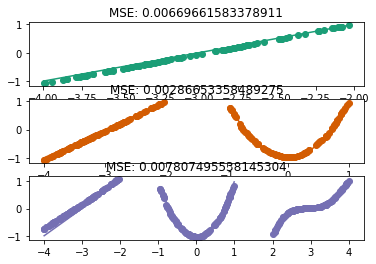

In [24]:
config = Dict2Class({'beta':0.005,
                     'num_epochs':1000,
                     'lr_hyper':1e-2,
                     'num_tasks':3,
                     'datalen_train':100,
                     'datalen_val':100,
                     'batch_size':32,
                     'seed':42,
                     'hnet_arch':'10,10',
                     'tnet_arch':'10,10',
                     'tnet_n_in':1,
                     'tnet_n_out':1,
                     'hnet_act':'sigmoid',
                     'tnet_act':'sigmoid',
                     'te_dim':2,
                     'use_sgd_change': False})

run(config)